# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
plt.style.use('default')

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


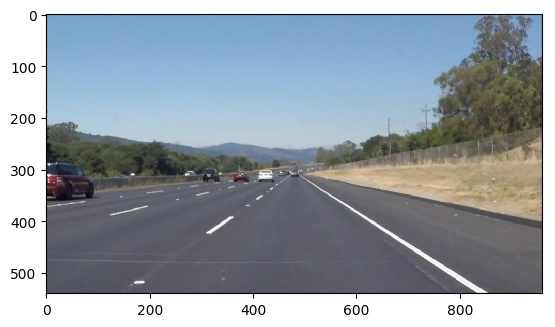

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [23]:
import math
import collections
LineSeg = collections.namedtuple('LineSeg', ['slope', 'intercept', 'y_bottom', 'y_top'])
Lanes = collections.namedtuple('Lanes', ['left', 'right'])

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def Canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def quad_center_vertices(img):
    rows, cols = img.shape[:2]
    # bottom_left, top_left, top_right, bottom_right
    return np.array([[cols*0.1, rows], [cols*0.4, rows*0.6], [cols*0.6, rows*0.6], [cols*0.9, rows]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_lane_lines(lines):
    left_lines = []
    left_lines_weights = []
    right_lines = []
    right_lines_weights = []
    y_top = 540 # determines the top end of lane lines
    y_bottom = 540 # determines the bottom end of lane lines
    
    for line in lines:
        x1, y1, x2, y2 = line[0][0], line[0][1], line[0][2], line[0][3]
        if x1 == x2:
            continue # skipping a vertical line
        if min(y1,y2) < y_top:
            y_top = min(y1,y2)
        if max(y1,y2) > y_bottom:
            y_bottom = max(y1,y2)
        
        slope = (y2-y1)/(x2-x1)
        intercept = y2 - slope*x2
        if slope < 0: # potential left lane
            left_lines.append([slope,intercept])
            left_lines_weights.append(y1-y2) # y1 > y2. use vertical height as weights to reject horizontal lines
        if slope > 0: # potential right lane
            right_lines.append([slope,intercept])
            right_lines_weights.append(y1-y2) 
        
    avg_left_line = np.average(left_lines,axis=0, weights=left_lines_weights)    
    avg_right_line = np.average(right_lines,axis=0, weights=right_lines_weights)
    
    print('left slope = {}, left intcpt = {}, y_top = {}'.format(avg_left_line[0],avg_left_line[1], y_top))
    print('right slope = {}, right intcpt = {}'.format(avg_right_line[0],avg_right_line[1]))
    
    return Lanes(LineSeg(*avg_left_line, y_bottom, y_top), LineSeg(*avg_right_line, y_bottom, y_top))

def get_line_ends(slope, intercept, y_bottom, y_top):
    """convert slop/intercept representation to two ends"""
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y_bottom - intercept)/slope)
    x2 = int((y_top - intercept)/slope)
    y1 = int(y_bottom)
    y2 = int(y_top)
    
    return [[x1, y1, x2, y2]]

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

Read image->grayscale->gaussian blur->Canny->

left slope = -0.7952224147778395, left intcpt = 689.533056333602, y_top = 324
right slope = 0.5675448959524818, right intcpt = 35.54893531474387
left slope = -0.6919915047820013, left intcpt = 640.8556627778646, y_top = 324
right slope = 0.6387200171868841, right intcpt = 0.3502512236570603
left slope = -0.7121569996290057, left intcpt = 651.1117101379862, y_top = 325
right slope = 0.5853658536585366, right intcpt = 35.42682926829272
left slope = -0.738664164998051, left intcpt = 662.8320040679417, y_top = 325
right slope = 0.5893106730049941, right intcpt = 30.71603547698145
left slope = -0.6928113961735582, left intcpt = 637.2092670150836, y_top = 324
right slope = 0.6135441963124051, right intcpt = 16.080025117965302


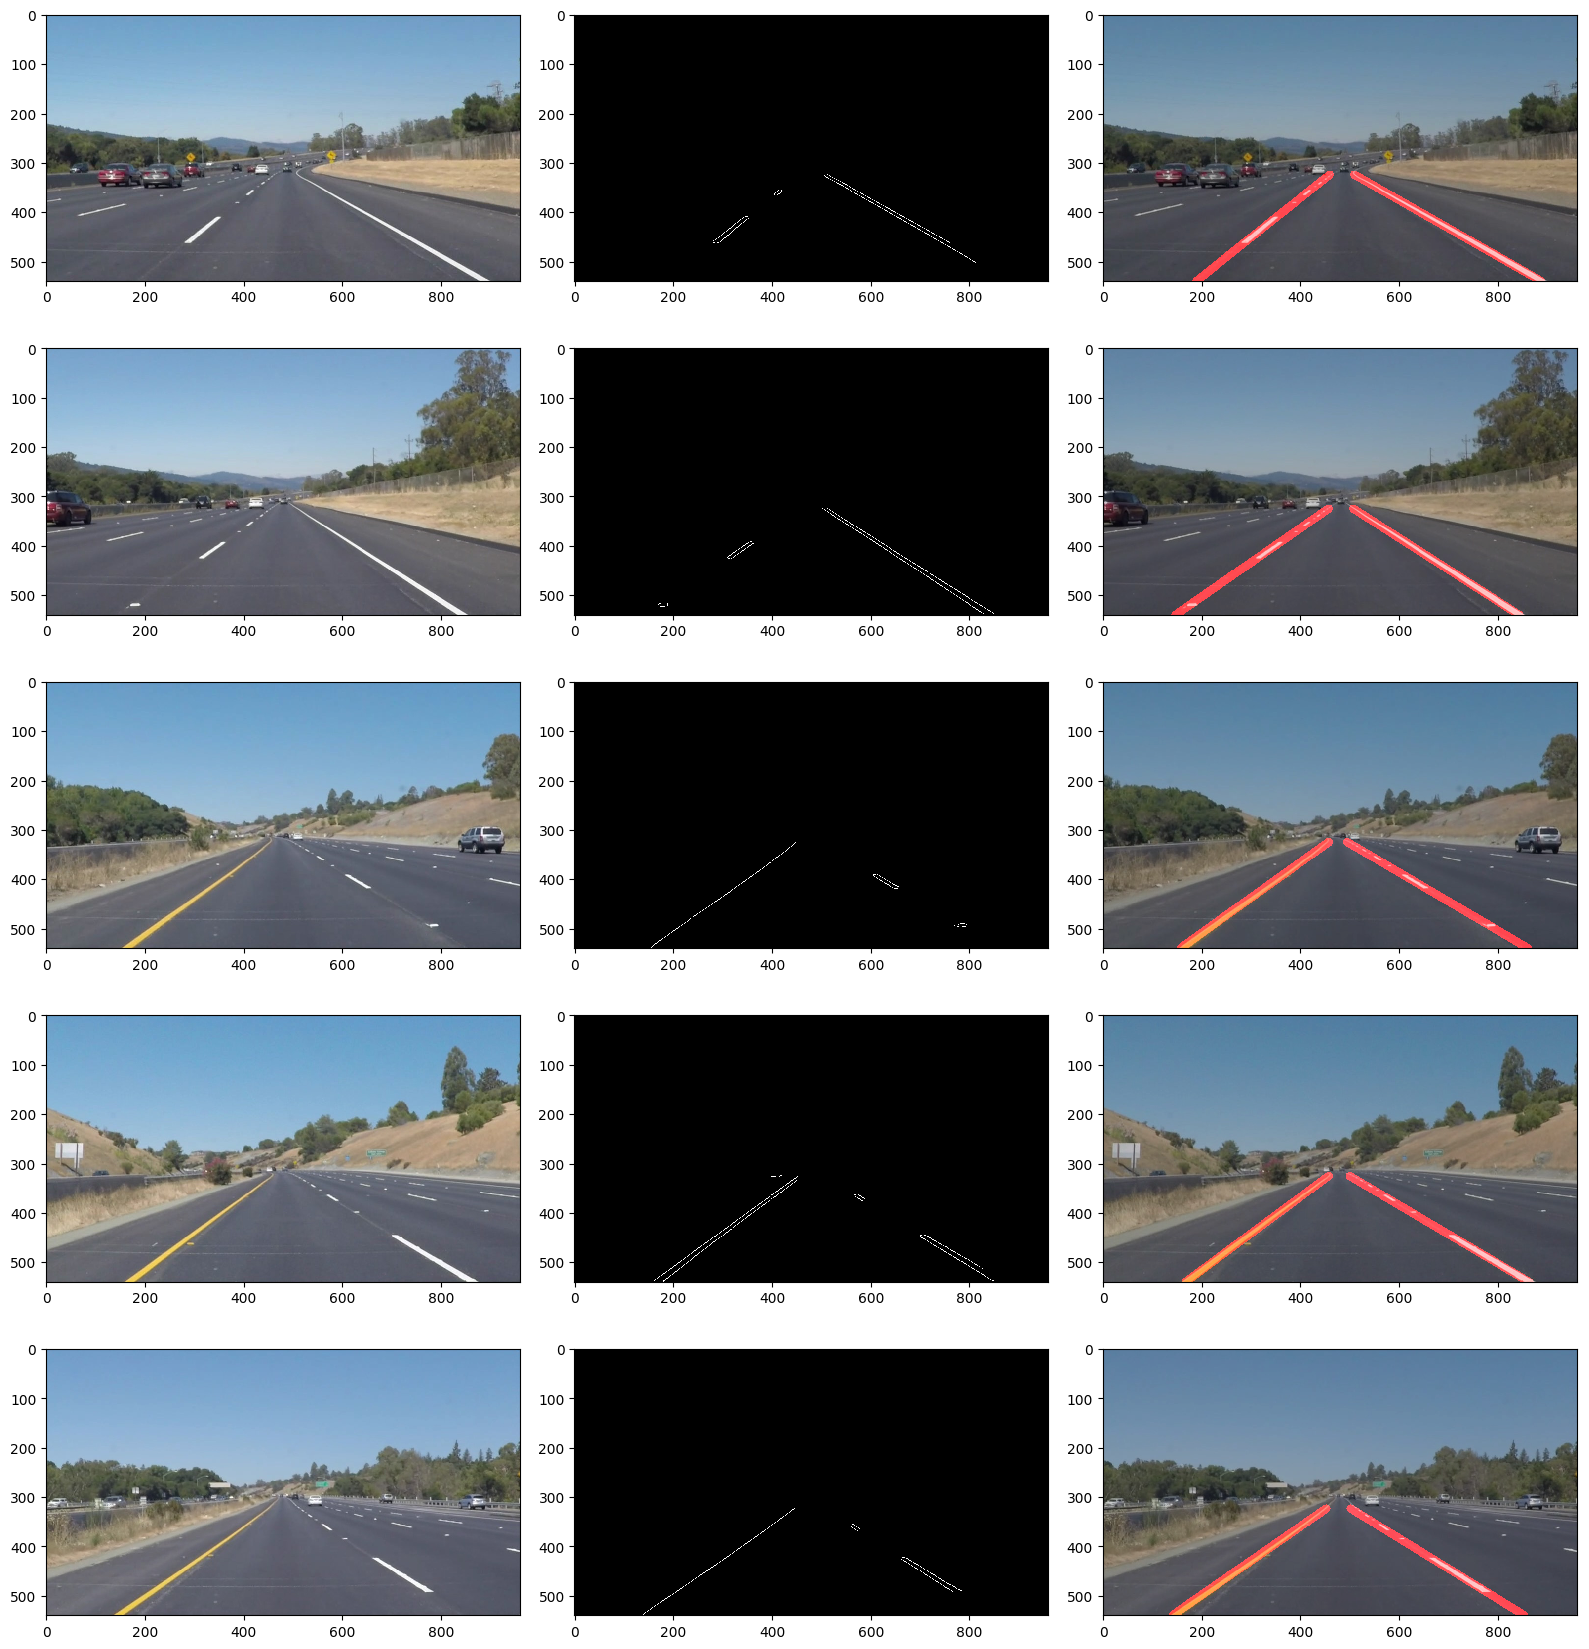

In [24]:
test_imgs = []

for file in os.listdir("test_images/"):
    test_imgs.append(mpimg.imread('test_images/' + file))

num = len(test_imgs)    
plt.figure(figsize=(16,20))
plt.subplot(num,3,1)

for i in np.arange(0, num-1):
    ## Original image
    plt.subplot(num,3,i*3+1)
    plt.imshow(test_imgs[i])
    
    ## grayScale->blur->canny->selectRegion
    plt.subplot(num,3,i*3+2)
    gray = grayscale(test_imgs[i])

    #blur = cv2.bilateralFilter(gray, 9,75,75)
    blur = gaussian_blur(gray, 15)
    can = Canny(blur, 50, 150)
    select = region_of_interest(can, quad_center_vertices(can))
    
    plt.imshow(select, cmap='gray')
    
    
    ## Hough->plot
    plt.subplot(num,3,i*3+3)
    
    rho = 1
    theta = np.pi/180
    threshold = 16
    min_line_length = 16
    max_line_gap = 16
    
    lines = cv2.HoughLinesP(select, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    lanes = get_lane_lines(lines)
    
    left_lane = get_line_ends(lanes.left.slope, lanes.left.intercept, lanes.left.y_bottom, lanes.left.y_top)
    right_lane = get_line_ends(lanes.right.slope, lanes.right.intercept, lanes.right.y_bottom, lanes.right.y_top)
    
    line_img = np.zeros((test_imgs[0].shape[0], test_imgs[0].shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, [left_lane, right_lane], thickness=16)
    
    color_select = np.dstack((select,select,select))
    combo = weighted_img(line_img, test_imgs[i])
    
    plt.imshow(combo)

plt.tight_layout()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray = grayscale(image)

    #blur = cv2.bilateralFilter(gray, 9,75,75)
    blur = gaussian_blur(gray, 15)
    can = Canny(blur, 50, 150)
    select = region_of_interest(can, quad_center_vertices(can))
   
    ## Hough->plot
    rho = 1
    theta = np.pi/180
    threshold = 16
    min_line_length = 16
    max_line_gap = 16
    
    lines = cv2.HoughLinesP(select, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    lanes = get_lane_lines(lines)
    
    left_lane = get_line_ends(lanes.left.slope, lanes.left.intercept, lanes.left.y_bottom, lanes.left.y_top)
    right_lane = get_line_ends(lanes.right.slope, lanes.right.intercept, lanes.right.y_bottom, lanes.right.y_top)
    
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, [left_lane, right_lane], thickness=16)
    
    color_select = np.dstack((select,select,select))
    result = weighted_img(line_img, image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 32.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:31<00:00, 25.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 32.2 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [25]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
type(clip3)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

left slope = -0.6508582463724073, left intcpt = 845.7584421038928, y_top = 432
right slope = 0.5919621776968764, right intcpt = 36.36006064269938
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

left slope = -0.6508582463724073, left intcpt = 845.7584421038928, y_top = 432
right slope = 0.5919621776968764, right intcpt = 36.36006064269938
left slope = -0.6553874929599557, left intcpt = 845.8340203499322, y_top = 432
right slope = 0.5947207433855416, right intcpt = 35.20445907254259


  1%|▋                                                                                 | 2/251 [00:00<00:13, 17.97it/s]

left slope = -0.6348185446968969, left intcpt = 837.9688732956552, y_top = 432
right slope = 0.5668461590786313, right intcpt = 64.75934522619417
left slope = -0.6466724147045674, left intcpt = 846.5481689661392, y_top = 432
right slope = 0.5772821126533175, right intcpt = 42.893241848679466


  2%|█▎                                                                                | 4/251 [00:00<00:13, 18.42it/s]

left slope = -0.6476060429842153, left intcpt = 844.7166166765508, y_top = 432
right slope = 0.5978066645056667, right intcpt = 37.72492763374139
left slope = -0.6547614782326455, left intcpt = 851.7365321858925, y_top = 434
right slope = 0.6400811252625254, right intcpt = -5.842227135788714


  2%|█▉                                                                                | 6/251 [00:00<00:13, 18.80it/s]

left slope = -0.6441033110612779, left intcpt = 845.5850070030342, y_top = 433
right slope = 0.6049726460235741, right intcpt = 34.46931798253853
left slope = -0.640939141114718, left intcpt = 843.636170226047, y_top = 432
right slope = 0.6131021909015096, right intcpt = 20.31982975504232


  3%|██▌                                                                               | 8/251 [00:00<00:12, 18.88it/s]

left slope = -0.6621469944909598, left intcpt = 855.1201497245904, y_top = 432
right slope = 0.6178785369220152, right intcpt = 11.406276052449991
left slope = -0.6652051158373686, left intcpt = 855.0852894342014, y_top = 432
right slope = 0.6166682399553254, right intcpt = 12.896995426610975


  4%|███▏                                                                             | 10/251 [00:00<00:12, 19.19it/s]

left slope = -0.6716985045034013, left intcpt = 860.2921166092206, y_top = 432
right slope = 0.6001954356270164, right intcpt = 25.4262585601997
left slope = -0.6822451072168877, left intcpt = 865.390317729742, y_top = 432
right slope = 0.605916317927154, right intcpt = 19.735879497956162


  5%|███▊                                                                             | 12/251 [00:00<00:12, 18.47it/s]

left slope = -0.6775034888595642, left intcpt = 864.9317084441188, y_top = 432
right slope = 0.6179542286091143, right intcpt = 9.832727774085376
left slope = -0.6860741218567425, left intcpt = 868.5817555588088, y_top = 432
right slope = 0.5971322109063526, right intcpt = 29.23207911550986


  6%|████▌                                                                            | 14/251 [00:00<00:13, 18.06it/s]

left slope = -0.6910653125357694, left intcpt = 870.3794229304489, y_top = 432
right slope = 0.605883173447433, right intcpt = 19.40027443883011
left slope = -0.6909590123791917, left intcpt = 870.5588369108121, y_top = 432
right slope = 0.5883827375762859, right intcpt = 34.52920662598081


  6%|█████▏                                                                           | 16/251 [00:00<00:12, 18.33it/s]

left slope = -0.6948636510853381, left intcpt = 870.7051203775359, y_top = 432
right slope = 0.5802220900707868, right intcpt = 48.470908122471094
left slope = -0.6837229952842472, left intcpt = 865.1518010949308, y_top = 432
right slope = 0.565989505400121, right intcpt = 50.07119530888019


  7%|█████▊                                                                           | 18/251 [00:00<00:12, 18.37it/s]

left slope = -0.6914646662554857, left intcpt = 868.6406900744391, y_top = 433
right slope = 0.5791217554375448, right intcpt = 43.81587115950126
left slope = -0.6808825433139872, left intcpt = 864.5496777816992, y_top = 432
right slope = 0.5900508610566116, right intcpt = 40.22187432343662
left slope = -0.6953901543111163, left intcpt = 873.5055082256971, y_top = 432
right slope = 0.5754386351244553, right intcpt = 48.54223675695016


  8%|██████▊                                                                          | 21/251 [00:01<00:12, 18.96it/s]

left slope = -0.6889172493524284, left intcpt = 867.8116664430054, y_top = 432
right slope = 0.5808947148099463, right intcpt = 43.89513202271175
left slope = -0.6766484575559581, left intcpt = 859.5274395868496, y_top = 432
right slope = 0.5940986269018702, right intcpt = 32.761746848824565
left slope = -0.6800173125261699, left intcpt = 863.3766745689263, y_top = 433
right slope = 0.5819876957177625, right intcpt = 46.24575050824054


 10%|███████▋                                                                         | 24/251 [00:01<00:11, 19.32it/s]

left slope = -0.6675255685654478, left intcpt = 854.6511693371176, y_top = 432
right slope = 0.5881466231182677, right intcpt = 40.03271634023332
left slope = -0.681031130545346, left intcpt = 863.7170212639803, y_top = 433
right slope = 0.5738815233992687, right intcpt = 54.9152600320213


 10%|████████▍                                                                        | 26/251 [00:01<00:11, 19.06it/s]

left slope = -0.6734751737598025, left intcpt = 857.6426260853353, y_top = 432
right slope = 0.5717256532655272, right intcpt = 50.54433571158924
left slope = -0.6768306121330933, left intcpt = 858.8324336061391, y_top = 433
right slope = 0.6454994824016563, right intcpt = -11.070339026915121


 11%|█████████                                                                        | 28/251 [00:01<00:11, 18.82it/s]

left slope = -0.672035753491802, left intcpt = 855.1779533055741, y_top = 433
right slope = 0.6235246784692389, right intcpt = 5.538352359847803
left slope = -0.6601554983409768, left intcpt = 849.3769869323838, y_top = 433
right slope = 0.6376641742260577, right intcpt = -2.2743212202807315


 12%|█████████▋                                                                       | 30/251 [00:01<00:11, 18.98it/s]

left slope = -0.9963464558300145, left intcpt = 1129.0758911472572, y_top = 434
right slope = 0.6166527075575864, right intcpt = 13.512176354667846
left slope = -0.6609306353560215, left intcpt = 850.0913015717507, y_top = 433
right slope = 0.6227507175746947, right intcpt = 12.210379124464042


 13%|██████████▎                                                                      | 32/251 [00:01<00:11, 19.26it/s]

left slope = -0.6596055440363802, left intcpt = 848.8788206721994, y_top = 434
right slope = 0.5951037940788146, right intcpt = 36.7656472795854
left slope = -0.6566294028150923, left intcpt = 846.5588262704525, y_top = 435
right slope = 0.6056596400498863, right intcpt = 26.024275673014646


 14%|██████████▉                                                                      | 34/251 [00:01<00:11, 19.29it/s]

left slope = -0.6761120198401182, left intcpt = 860.8611885286442, y_top = 446
right slope = 0.6002484207537196, right intcpt = 33.197887817525
left slope = -0.9049451673137906, left intcpt = 1055.053650736725, y_top = 437
right slope = 0.5876159701567799, right intcpt = 44.52474380949502


 14%|███████████▌                                                                     | 36/251 [00:01<00:11, 19.15it/s]

left slope = -0.6537422927299704, left intcpt = 850.4177373527141, y_top = 437
right slope = 0.6050890175859853, right intcpt = 28.210396624769352
left slope = -0.6326074364683298, left intcpt = 837.9587818791629, y_top = 437
right slope = 0.6025067856208145, right intcpt = 29.350971417484853


 15%|████████████▎                                                                    | 38/251 [00:01<00:10, 19.38it/s]

left slope = -0.6497286650246894, left intcpt = 845.8339057258489, y_top = 437
right slope = 0.5816161985659957, right intcpt = 45.73858043787052
left slope = -0.6728679083814714, left intcpt = 859.2917151838021, y_top = 443
right slope = 0.5736844003439004, right intcpt = 50.52328017767418
left slope = -0.6625968946580899, left intcpt = 854.828571254251, y_top = 432
right slope = 0.5881574563034173, right intcpt = 44.15380926599723


 16%|█████████████▏                                                                   | 41/251 [00:02<00:10, 20.04it/s]

left slope = -0.6647536066066323, left intcpt = 856.6047476801655, y_top = 432
right slope = 0.5942045011521798, right intcpt = 38.00987513126235
left slope = -0.6419316161127198, left intcpt = 844.5541259342341, y_top = 432
right slope = 0.6024126585218446, right intcpt = 25.245937258346114
left slope = -0.6430334864897307, left intcpt = 843.8714415313486, y_top = 432
right slope = 0.5698386586632985, right intcpt = 54.06043645040761


 18%|██████████████▏                                                                  | 44/251 [00:02<00:10, 19.79it/s]

left slope = -0.6477480636802835, left intcpt = 847.2609456695724, y_top = 432
right slope = 0.5728513904582451, right intcpt = 49.35750541460856
left slope = -0.6448102179765665, left intcpt = 846.612864583301, y_top = 432
right slope = 0.5859870698000403, right intcpt = 40.75995287509729


 18%|██████████████▊                                                                  | 46/251 [00:02<00:10, 19.37it/s]

left slope = -0.6453633987593662, left intcpt = 848.3722007930513, y_top = 432
right slope = 0.5759725611687794, right intcpt = 50.71435542988673
left slope = -0.6574030044304278, left intcpt = 853.8333598243785, y_top = 432
right slope = 0.5797193576506382, right intcpt = 48.23762223116929


 19%|███████████████▍                                                                 | 48/251 [00:02<00:12, 16.74it/s]

left slope = -0.6576100756491619, left intcpt = 853.9404337289694, y_top = 432
right slope = 0.5813517237118687, right intcpt = 46.61964990093488
left slope = -0.6588495140994135, left intcpt = 855.0250305539845, y_top = 432
right slope = 0.602320317237166, right intcpt = 32.89724246867635


 20%|████████████████▏                                                                | 50/251 [00:02<00:12, 16.28it/s]

left slope = -0.660151971347288, left intcpt = 853.9901983077916, y_top = 432
right slope = 0.5952407027189758, right intcpt = 31.636071298988327
left slope = -0.6714549623652499, left intcpt = 859.0207983938471, y_top = 432
right slope = 0.6108374384236454, right intcpt = 19.876847290640423


 21%|████████████████▊                                                                | 52/251 [00:02<00:13, 15.18it/s]

left slope = -0.6681874578552909, left intcpt = 859.2763426047153, y_top = 432
right slope = 0.6143448748287458, right intcpt = 27.046528210237877
left slope = -0.6764742161315352, left intcpt = 862.828978858133, y_top = 432
right slope = 0.6302325074728722, right intcpt = 2.758438993284713


 22%|█████████████████▍                                                               | 54/251 [00:02<00:13, 14.42it/s]

left slope = -0.6736517813930487, left intcpt = 861.4112889066145, y_top = 432
right slope = 0.5796217942119536, right intcpt = 52.19916202145753
left slope = -0.6745556670186337, left intcpt = 862.079866570424, y_top = 432
right slope = 0.6020688982762129, right intcpt = 30.98295174627031


 22%|██████████████████                                                               | 56/251 [00:03<00:15, 12.77it/s]

left slope = -0.6859172971056131, left intcpt = 867.205209909278, y_top = 432
right slope = 0.5971498325100777, right intcpt = 30.687463805143956
left slope = -0.6786660140437175, left intcpt = 862.9186285143645, y_top = 432
right slope = 0.5581294784316483, right intcpt = 63.728567119712935


 23%|██████████████████▋                                                              | 58/251 [00:03<00:14, 13.77it/s]

left slope = -0.6955933546637901, left intcpt = 872.9148886619848, y_top = 432
right slope = 0.5837403173684977, right intcpt = 42.14229585614544
left slope = -0.6879705248007271, left intcpt = 867.965048509923, y_top = 432
right slope = 0.5955619521213825, right intcpt = 34.20162433574337


 24%|███████████████████▎                                                             | 60/251 [00:03<00:13, 13.66it/s]

left slope = -0.6731041484298391, left intcpt = 858.3177179301856, y_top = 432
right slope = 0.5935885492398901, right intcpt = 35.40376387944398
left slope = -0.6722442170359803, left intcpt = 858.7401565519408, y_top = 432
right slope = 0.6036757165937403, right intcpt = 29.04477066874303


 25%|████████████████████                                                             | 62/251 [00:03<00:14, 12.89it/s]

left slope = -0.6713224001757242, left intcpt = 859.191035068381, y_top = 432
right slope = 0.591111123282176, right intcpt = 35.270907133801856
left slope = -0.669232450711585, left intcpt = 858.9515583817465, y_top = 432
right slope = 0.6024015474575175, right intcpt = 19.024942253020615


 25%|████████████████████▋                                                            | 64/251 [00:03<00:15, 12.46it/s]

left slope = -0.6628201573385853, left intcpt = 855.3916199594615, y_top = 432
right slope = 0.606220398348058, right intcpt = 27.46490720894975
left slope = -0.6601914645321096, left intcpt = 857.2184020208819, y_top = 432
right slope = 0.5866345735517386, right intcpt = 44.20629614263773


 26%|█████████████████████▎                                                           | 66/251 [00:03<00:14, 12.67it/s]

left slope = -0.6645710485321507, left intcpt = 859.3795023980592, y_top = 432
right slope = 0.5912184018253189, right intcpt = 30.77216674926217
left slope = -0.6725717639569395, left intcpt = 866.1529959075805, y_top = 432
right slope = 0.5837030955171143, right intcpt = 34.70287406711996


 27%|█████████████████████▉                                                           | 68/251 [00:04<00:14, 12.89it/s]

left slope = -0.6765345936400989, left intcpt = 866.5630645743819, y_top = 432
right slope = 0.5612440812013625, right intcpt = 52.20357638101453
left slope = -0.6795579620752507, left intcpt = 868.1676864064077, y_top = 432
right slope = 0.5859521798967093, right intcpt = 38.606921104521106


 28%|██████████████████████▌                                                          | 70/251 [00:04<00:14, 12.72it/s]

left slope = -0.6787532427175736, left intcpt = 869.0265722485101, y_top = 432
right slope = 0.5860814359256922, right intcpt = 35.6657668299028
left slope = -0.6890657159547253, left intcpt = 874.5200339893862, y_top = 432
right slope = 0.586027275895971, right intcpt = 35.038363474270504


 29%|███████████████████████▏                                                         | 72/251 [00:04<00:13, 13.07it/s]

left slope = -0.9693024174404234, left intcpt = 1106.9595807140518, y_top = 432
right slope = 0.6089283875439414, right intcpt = 13.908061045331154
left slope = -0.686064008348189, left intcpt = 873.5454840417367, y_top = 432
right slope = 0.5532321757005301, right intcpt = 72.92934382776156


 29%|███████████████████████▉                                                         | 74/251 [00:04<00:13, 12.66it/s]

left slope = -0.695265267432612, left intcpt = 881.4598380110482, y_top = 432
right slope = 0.5783783653867614, right intcpt = 37.502641390621925
left slope = -0.6886794055389533, left intcpt = 877.6052504598528, y_top = 432
right slope = 0.5645511377007637, right intcpt = 50.39361169889217


 30%|████████████████████████▌                                                        | 76/251 [00:04<00:13, 12.63it/s]

left slope = -0.6982846696505918, left intcpt = 883.6839217051089, y_top = 433
right slope = 0.5709062818881894, right intcpt = 45.281033433050986
left slope = -0.6829270602273642, left intcpt = 875.5025160829463, y_top = 433
right slope = 0.570950720032266, right intcpt = 46.39661377529571


 31%|█████████████████████████▏                                                       | 78/251 [00:04<00:13, 12.40it/s]

left slope = -0.6966738657945184, left intcpt = 881.7382281066472, y_top = 433
right slope = 0.5490922173524717, right intcpt = 61.2850283559242
left slope = -0.7048586391482181, left intcpt = 885.3394630417662, y_top = 432
right slope = 0.5481358498543402, right intcpt = 63.361353897643454


 32%|█████████████████████████▊                                                       | 80/251 [00:05<00:14, 12.16it/s]

left slope = -0.7190215596362465, left intcpt = 893.803594378809, y_top = 432
right slope = 0.5566651369765601, right intcpt = 57.114541597648795
left slope = -0.7140764749552563, left intcpt = 890.6109083193128, y_top = 432
right slope = 0.5494363559623692, right intcpt = 64.64291088579006


 33%|██████████████████████████▍                                                      | 82/251 [00:05<00:14, 11.62it/s]

left slope = -0.7039942494102049, left intcpt = 887.0262651069974, y_top = 433
right slope = 0.5615472593922243, right intcpt = 55.68566661160695
left slope = -0.7003100102823921, left intcpt = 881.6619024660605, y_top = 433
right slope = 0.5702804956190558, right intcpt = 49.317180562369444


 33%|███████████████████████████                                                      | 84/251 [00:05<00:14, 11.63it/s]

left slope = -0.7013228436213195, left intcpt = 884.9778255179148, y_top = 433
right slope = 0.5688148891032465, right intcpt = 44.750110266491724
left slope = -0.7228225950119413, left intcpt = 893.8230840953627, y_top = 434
right slope = 0.5912256321655563, right intcpt = 27.625075912789377


 34%|███████████████████████████▊                                                     | 86/251 [00:05<00:13, 11.96it/s]

left slope = -0.7126060378611895, left intcpt = 888.7838713587605, y_top = 434
right slope = 0.5660108219292623, right intcpt = 46.044441790807134
left slope = -0.7057479608332411, left intcpt = 885.5344052724196, y_top = 432
right slope = 0.5211256241627086, right intcpt = 83.6964437949093


 35%|████████████████████████████▍                                                    | 88/251 [00:05<00:13, 12.12it/s]

left slope = -0.7146862193281771, left intcpt = 891.6220325136716, y_top = 432
right slope = 0.5359871071288858, right intcpt = 69.73733698910696
left slope = -0.7331472804342875, left intcpt = 903.8378218845944, y_top = 435
right slope = 0.5443897126678359, right intcpt = 69.03526749865925


 36%|█████████████████████████████                                                    | 90/251 [00:05<00:13, 12.06it/s]

left slope = -0.7402697180920268, left intcpt = 904.2785721405871, y_top = 435
right slope = 0.5259125294057657, right intcpt = 85.36671632544473
left slope = -0.7463433595790823, left intcpt = 908.1435797706498, y_top = 433
right slope = 0.5411062983324454, right intcpt = 68.05957420318943


 37%|█████████████████████████████▋                                                   | 92/251 [00:06<00:13, 11.95it/s]

left slope = -0.760474813748856, left intcpt = 915.5308833111084, y_top = 432
right slope = 0.547320733710359, right intcpt = 66.84051717073667
left slope = -0.7470739285076524, left intcpt = 905.6845617227096, y_top = 434
right slope = 0.5547436426687814, right intcpt = 70.21568749081183


 37%|██████████████████████████████▎                                                  | 94/251 [00:06<00:12, 12.68it/s]

left slope = -0.7622621775546587, left intcpt = 914.1704369013944, y_top = 434
right slope = 0.5317255743242678, right intcpt = 79.79193854531363
left slope = -0.7669271052745219, left intcpt = 917.014970637724, y_top = 435
right slope = 0.5298610904380621, right intcpt = 88.67658386589541


 38%|██████████████████████████████▉                                                  | 96/251 [00:06<00:12, 12.12it/s]

left slope = -0.7850472230323641, left intcpt = 925.1217066938752, y_top = 435
right slope = 0.5429365113825158, right intcpt = 76.56269572407913
left slope = -0.7449863335970874, left intcpt = 904.1634455579535, y_top = 436
right slope = 0.6181023763470572, right intcpt = -5.569359629731968


 39%|███████████████████████████████▋                                                 | 98/251 [00:06<00:12, 12.09it/s]

left slope = -0.7531324746271302, left intcpt = 906.9346300875942, y_top = 436
right slope = 0.5251824446401495, right intcpt = 71.68899103892214
left slope = -0.7490900503899877, left intcpt = 902.2669791138567, y_top = 435
right slope = 0.4679172701873374, right intcpt = 135.96781681688898


 40%|███████████████████████████████▊                                                | 100/251 [00:06<00:12, 12.16it/s]

left slope = -0.7551302418327928, left intcpt = 905.1557537419486, y_top = 436
right slope = 0.5093591017946492, right intcpt = 90.13085546761957
left slope = -0.7232575939673312, left intcpt = 887.1603085532721, y_top = 434
right slope = 0.5273876196902513, right intcpt = 72.77957401516609


 41%|████████████████████████████████▌                                               | 102/251 [00:06<00:11, 12.44it/s]

left slope = -0.7316475488752815, left intcpt = 892.1453338718626, y_top = 437
right slope = 0.5907778903523584, right intcpt = 15.609329055499268
left slope = -0.6379819965743821, left intcpt = 843.752334299335, y_top = 437
right slope = 0.5094952163197831, right intcpt = 94.71663994872857


 41%|█████████████████████████████████▏                                              | 104/251 [00:07<00:12, 11.61it/s]

left slope = -0.6340957232312046, left intcpt = 845.5869747801536, y_top = 439
right slope = 0.5412823682932915, right intcpt = 71.32545337205964
left slope = -0.5267926595256122, left intcpt = 802.7582382971699, y_top = 439
right slope = 0.5342227723985677, right intcpt = 81.36077074314129


 42%|█████████████████████████████████▊                                              | 106/251 [00:07<00:11, 12.12it/s]

left slope = -0.23702205515537814, left intcpt = 683.0920193644812, y_top = 438
right slope = 0.5198177258268769, right intcpt = 95.68965753198353
left slope = -0.2674365845224939, left intcpt = 723.217247894898, y_top = 439
right slope = 0.5686908528774661, right intcpt = 54.45146073169051


 43%|██████████████████████████████████▍                                             | 108/251 [00:07<00:11, 12.68it/s]

left slope = -0.2873514739820899, left intcpt = 612.5401623443288, y_top = 438
right slope = 0.5519317179953462, right intcpt = 71.24436573775661
left slope = -0.3154713944355888, left intcpt = 628.5922335087936, y_top = 439
right slope = 0.6524550373736794, right intcpt = -35.88633877951878


 44%|███████████████████████████████████                                             | 110/251 [00:07<00:11, 11.77it/s]

left slope = -0.30788751504540984, left intcpt = 623.0894890031733, y_top = 439
right slope = 0.4074074074074074, right intcpt = 147.14814814814815
left slope = -0.29941986775780693, left intcpt = 616.2170698188069, y_top = 437
right slope = 0.4545454545454545, right intcpt = 105.2727272727273


 45%|███████████████████████████████████▋                                            | 112/251 [00:07<00:11, 12.34it/s]

left slope = -0.280117633833682, left intcpt = 602.5840680064141, y_top = 436
right slope = 0.44999999999999996, right intcpt = 107.44999999999999
left slope = -0.3046875, left intcpt = 614.0234375, y_top = 435
right slope = 0.02631578947368421, right intcpt = 416.92105263157896


 45%|████████████████████████████████████▎                                           | 114/251 [00:07<00:10, 12.76it/s]

left slope = -0.30028020049007587, left intcpt = 612.7562897344225, y_top = 435
right slope = 0.015873015873015872, right intcpt = 423.74603174603175
left slope = -0.2889259707650956, left intcpt = 613.1916095002375, y_top = 441
right slope = 0.3188873626373626, right intcpt = 211.1567994505494


 46%|████████████████████████████████████▉                                           | 116/251 [00:08<00:11, 11.79it/s]

left slope = -0.3083425404575173, left intcpt = 624.0991126620961, y_top = 441
right slope = 0.43478260869565216, right intcpt = 120.91304347826087
left slope = -0.2864490035760364, left intcpt = 614.7398257297568, y_top = 445
right slope = 0.35714285714285715, right intcpt = 188.5


 47%|█████████████████████████████████████▌                                          | 118/251 [00:08<00:11, 11.60it/s]

left slope = -0.3904582193824175, left intcpt = 657.9239892447805, y_top = 432
right slope = 0.37037037037037035, right intcpt = 176.66666666666669
left slope = -0.3007063699661741, left intcpt = 620.313105562083, y_top = 436
right slope = 0.5659208353092144, right intcpt = 52.97765627508747


 48%|██████████████████████████████████████▏                                         | 120/251 [00:08<00:10, 12.30it/s]

left slope = -0.3203125, left intcpt = 631.4140625, y_top = 451
right slope = 0.587342393878107, right intcpt = 40.93386426811377
left slope = -0.3077614085519224, left intcpt = 619.9271469637083, y_top = 447
right slope = 0.58979625003301, right intcpt = 38.268846452758


 49%|██████████████████████████████████████▉                                         | 122/251 [00:08<00:12, 10.32it/s]

left slope = -0.3227670968439175, left intcpt = 627.7188854396863, y_top = 448
right slope = 0.5918713466719843, right intcpt = 37.942620169122684
left slope = -0.30111408199643497, left intcpt = 616.5409982174689, y_top = 450
right slope = 0.5585869607743555, right intcpt = 64.36275560181939


 49%|███████████████████████████████████████▌                                        | 124/251 [00:08<00:12, 10.44it/s]

left slope = -0.30275466576919363, left intcpt = 621.3337494273934, y_top = 449
right slope = 0.364766081871345, right intcpt = 206.23318713450286
left slope = -0.3229166666666667, left intcpt = 628.4375, y_top = 454
right slope = 0.43478260869565216, right intcpt = 121.2173913043478


 50%|████████████████████████████████████████▏                                       | 126/251 [00:08<00:10, 11.43it/s]

left slope = -0.2723022876862344, left intcpt = 618.7956749220064, y_top = 451
right slope = 0.4166666666666667, right intcpt = 136.0
left slope = -0.27758367473921247, left intcpt = 612.8988301621357, y_top = 453
right slope = 0.365702479338843, right intcpt = 176.82851239669418


 51%|████████████████████████████████████████▊                                       | 128/251 [00:09<00:11, 10.68it/s]

left slope = -0.26143306156112306, left intcpt = 610.7967956418818, y_top = 455
right slope = 0.4063095238095238, right intcpt = 143.8472619047619
left slope = -0.2462083059615935, left intcpt = 590.8482475316733, y_top = 456
right slope = 0.41735537190082644, right intcpt = 133.6776859504132


 52%|█████████████████████████████████████████▍                                      | 130/251 [00:09<00:11, 10.89it/s]

left slope = -0.2963899282030539, left intcpt = 617.5562746485995, y_top = 467
right slope = 0.4, right intcpt = 150.59999999999997
left slope = -0.26342704587555843, left intcpt = 600.2361468889616, y_top = 467
right slope = 0.6360419147400992, right intcpt = 0.4188565303474937


 53%|██████████████████████████████████████████                                      | 132/251 [00:09<00:10, 11.74it/s]

left slope = -0.2791837750404379, left intcpt = 607.8970013686699, y_top = 467
right slope = 0.5774665270492484, right intcpt = 53.08373121302496
left slope = -0.2067423460612315, left intcpt = 604.6599587203302, y_top = 471
right slope = 0.6152613609891723, right intcpt = 17.821280166636917


 53%|██████████████████████████████████████████▋                                     | 134/251 [00:09<00:10, 11.28it/s]

left slope = -0.255514705882353, left intcpt = 635.7261029411765, y_top = 473
right slope = 0.6121283103319235, right intcpt = 15.026183296505746
left slope = -0.4866335528518808, left intcpt = 743.8289987721844, y_top = 463
right slope = 0.5859183230150973, right intcpt = 40.03704246768762


 54%|███████████████████████████████████████████▎                                    | 136/251 [00:09<00:11, 10.05it/s]

left slope = -0.39291043552407184, left intcpt = 695.7184794372293, y_top = 467
right slope = 0.31739318534431316, right intcpt = 220.8496688148944
left slope = -0.4385569544727835, left intcpt = 722.3617951015532, y_top = 477
right slope = 0.24706959706959708, right intcpt = 413.80732600732597


 55%|███████████████████████████████████████████▉                                    | 138/251 [00:10<00:11, 10.15it/s]

left slope = -0.5029150373266974, left intcpt = 758.1582651972983, y_top = 480
right slope = 0.27555555555555555, right intcpt = 356.8977777777778
left slope = -0.4524516275487351, left intcpt = 742.3691666815298, y_top = 468
right slope = 0.3684210526315789, right intcpt = 197.94736842105266


 56%|████████████████████████████████████████████▌                                   | 140/251 [00:10<00:10, 10.59it/s]

left slope = -0.2948470209339774, left intcpt = 664.4978548424201, y_top = 471
right slope = 0.572233783409313, right intcpt = 51.14179556206479
left slope = -0.48555251518876413, left intcpt = 755.3399566686468, y_top = 473
right slope = 0.6170177119116008, right intcpt = 17.70035759725462


 57%|█████████████████████████████████████████████▎                                  | 142/251 [00:10<00:10, 10.29it/s]

left slope = -0.3841865742701134, left intcpt = 707.1075913006589, y_top = 473
right slope = 0.6105118781246933, right intcpt = 23.98459415883295
left slope = -0.5302472019864176, left intcpt = 778.2778449532505, y_top = 478
right slope = 0.6021074677164644, right intcpt = 32.594924570865516


 57%|█████████████████████████████████████████████▉                                  | 144/251 [00:10<00:09, 11.22it/s]

left slope = -0.5143787824651258, left intcpt = 777.1149459473083, y_top = 482
right slope = 0.6113261894820134, right intcpt = 22.66177726772172
left slope = -0.5348387779396176, left intcpt = 787.9390759068142, y_top = 432
right slope = 0.6137907671503918, right intcpt = 22.17947834543391


 58%|██████████████████████████████████████████████▌                                 | 146/251 [00:10<00:10, 10.14it/s]

left slope = -0.5741676958416354, left intcpt = 805.564370097525, y_top = 492
right slope = 0.5943221959008782, right intcpt = 40.35721254667609
left slope = -0.5959629233297656, left intcpt = 813.8857592558704, y_top = 450
right slope = 0.5987086047985702, right intcpt = 34.74672901274977


 59%|███████████████████████████████████████████████▏                                | 148/251 [00:11<00:09, 10.46it/s]

left slope = -0.559692383680608, left intcpt = 795.1740367563903, y_top = 432
right slope = 0.5428270363127538, right intcpt = 121.23490723649059
left slope = -0.5382580413129544, left intcpt = 785.6438277673502, y_top = 432
right slope = 0.5928272445926858, right intcpt = 45.31903666112495


 60%|███████████████████████████████████████████████▊                                | 150/251 [00:11<00:08, 11.37it/s]

left slope = -0.5859045353736582, left intcpt = 805.5435862458015, y_top = 432
right slope = 0.6009662257122489, right intcpt = 34.635434834241266
left slope = -0.5967029569657977, left intcpt = 812.9437458221258, y_top = 432
right slope = 0.5961637106384795, right intcpt = 40.936325037956614


 61%|████████████████████████████████████████████████▍                               | 152/251 [00:11<00:08, 11.17it/s]

left slope = -0.5915160796335833, left intcpt = 807.2121810906002, y_top = 432
right slope = 0.6004759384381679, right intcpt = 37.99363549976307
left slope = -0.5854762291201479, left intcpt = 808.7086601323889, y_top = 432
right slope = 0.5961229206580432, right intcpt = 45.97607341336959


 61%|█████████████████████████████████████████████████                               | 154/251 [00:11<00:08, 11.70it/s]

left slope = -0.6001340698661976, left intcpt = 813.3370865048387, y_top = 432
right slope = 0.6381863184593715, right intcpt = 5.4661921890413945
left slope = -0.588637043799764, left intcpt = 807.6973765127877, y_top = 432
right slope = 0.6119761251904053, right intcpt = 33.42318630264242


 62%|█████████████████████████████████████████████████▋                              | 156/251 [00:11<00:08, 11.73it/s]

left slope = -0.5765677545859429, left intcpt = 800.2809476721244, y_top = 432
right slope = 0.6116403866932926, right intcpt = 32.46402443799231
left slope = -0.5730592150741215, left intcpt = 794.6843103612327, y_top = 432
right slope = 0.6567181974893214, right intcpt = -6.335991985409537


 63%|██████████████████████████████████████████████████▎                             | 158/251 [00:11<00:08, 11.27it/s]

left slope = -0.5486791985978248, left intcpt = 782.0531023623821, y_top = 432
right slope = 0.7236480000816918, right intcpt = -70.80203259504336
left slope = -0.554465497198098, left intcpt = 785.0100929638954, y_top = 432
right slope = 0.6781615178927006, right intcpt = -35.47891790407919


 64%|██████████████████████████████████████████████████▉                             | 160/251 [00:12<00:07, 11.67it/s]

left slope = -0.5493222179817884, left intcpt = 784.0583258586311, y_top = 432
right slope = 0.6898730603919282, right intcpt = -41.08644368762294
left slope = -0.5493179500696522, left intcpt = 781.1125297150622, y_top = 432
right slope = 0.6236425664150242, right intcpt = 11.998057793315414


 65%|███████████████████████████████████████████████████▋                            | 162/251 [00:12<00:07, 11.74it/s]

left slope = -0.5416062449518619, left intcpt = 778.8586763951811, y_top = 432
right slope = 0.6506138689526847, right intcpt = -13.261513157894715
left slope = -0.5449444186658313, left intcpt = 781.6787630146778, y_top = 432
right slope = 0.6197009453114124, right intcpt = 17.44447719395661


 65%|████████████████████████████████████████████████████▎                           | 164/251 [00:12<00:07, 11.19it/s]

left slope = -0.55689575694982, left intcpt = 791.814941120464, y_top = 432
right slope = 0.6232727365818834, right intcpt = 13.272638335157557
left slope = -0.5574176244268999, left intcpt = 795.236261499825, y_top = 432
right slope = 0.629800145419238, right intcpt = 7.834275832338191


 66%|████████████████████████████████████████████████████▉                           | 166/251 [00:12<00:07, 10.81it/s]

left slope = -0.5659862433858514, left intcpt = 800.7763519703644, y_top = 432
right slope = 0.6179069288187292, right intcpt = 21.560912608307774
left slope = -0.5501087014391117, left intcpt = 793.3022696831885, y_top = 432
right slope = 0.6363494988358854, right intcpt = 1.6712358068835909


 67%|█████████████████████████████████████████████████████▌                          | 168/251 [00:12<00:07, 11.64it/s]

left slope = -0.5617870018691559, left intcpt = 803.2168992007662, y_top = 432
right slope = 0.6210880044974186, right intcpt = 21.670556272999786
left slope = -0.5760542084840332, left intcpt = 812.1627291485553, y_top = 432
right slope = 0.5936285442676315, right intcpt = 44.238296757748905


 68%|██████████████████████████████████████████████████████▏                         | 170/251 [00:13<00:07, 10.38it/s]

left slope = -0.5975938130614632, left intcpt = 826.6184082333776, y_top = 432
right slope = 0.6202090592334495, right intcpt = 19.491289198606307
left slope = -0.6070433191192167, left intcpt = 832.5621582368886, y_top = 432
right slope = 0.6516429599762933, right intcpt = -6.2762472845806725


 69%|██████████████████████████████████████████████████████▊                         | 172/251 [00:13<00:06, 11.30it/s]

left slope = -0.6156266190617521, left intcpt = 832.8879794651461, y_top = 432
right slope = 0.6117107420653937, right intcpt = 25.83521833017495
left slope = -0.6035126535604471, left intcpt = 824.8983431844816, y_top = 432
right slope = 0.610782816533471, right intcpt = 25.635642860645103


 69%|███████████████████████████████████████████████████████▍                        | 174/251 [00:13<00:07, 10.58it/s]

left slope = -0.6384597587839769, left intcpt = 842.7631286274668, y_top = 432
right slope = 0.6105655634687892, right intcpt = 18.955458734813604
left slope = -0.6307798225363925, left intcpt = 836.5489853783216, y_top = 433
right slope = 0.6149996057861813, right intcpt = 16.023430140781766


 70%|████████████████████████████████████████████████████████                        | 176/251 [00:13<00:06, 11.38it/s]

left slope = -0.6385582483224914, left intcpt = 839.4956689416397, y_top = 432
right slope = 0.6126092826060845, right intcpt = 16.900948970139144
left slope = -0.6512707165282426, left intcpt = 848.5142030880419, y_top = 435
right slope = 0.600406567630131, right intcpt = 28.237902850225808


 71%|████████████████████████████████████████████████████████▋                       | 178/251 [00:13<00:06, 10.84it/s]

left slope = -0.6422073154591251, left intcpt = 843.8162516731672, y_top = 432
right slope = 0.6063415919332382, right intcpt = 22.430747915149404
left slope = -0.6537675362612213, left intcpt = 851.1096163589624, y_top = 433
right slope = 0.5878235502890297, right intcpt = 43.53730674437678


 72%|█████████████████████████████████████████████████████████▎                      | 180/251 [00:13<00:06, 10.38it/s]

left slope = -0.6510038378698905, left intcpt = 846.847054011612, y_top = 435
right slope = 0.577810339681149, right intcpt = 51.28858675096568
left slope = -0.6529567683384906, left intcpt = 849.4394914395085, y_top = 432
right slope = 0.5623312048833871, right intcpt = 62.58035024045459


 73%|██████████████████████████████████████████████████████████                      | 182/251 [00:14<00:06, 10.61it/s]

left slope = -0.6554570634506932, left intcpt = 852.0930850055953, y_top = 432
right slope = 0.6625676372967394, right intcpt = -26.330843304604908
left slope = -0.6350511219041759, left intcpt = 840.5991958248158, y_top = 432
right slope = 0.5816226257402729, right intcpt = 40.52092972387089


 73%|██████████████████████████████████████████████████████████▋                     | 184/251 [00:14<00:06, 10.75it/s]

left slope = -0.648377893910221, left intcpt = 849.2307880770164, y_top = 432
right slope = 0.5963473162781918, right intcpt = 29.500647394080577
left slope = -0.6570005081518048, left intcpt = 853.3183108116664, y_top = 432
right slope = 0.5874107908732201, right intcpt = 36.43939740950424


 74%|███████████████████████████████████████████████████████████▎                    | 186/251 [00:14<00:06, 10.81it/s]

left slope = -0.6515176522525352, left intcpt = 852.6971704049137, y_top = 432
right slope = 0.5841071428571428, right intcpt = 41.7168743078627
left slope = -0.6536501727007165, left intcpt = 853.5532713026365, y_top = 432
right slope = 0.6011107287887367, right intcpt = 26.29026155823678


 75%|███████████████████████████████████████████████████████████▉                    | 188/251 [00:14<00:06, 10.11it/s]

left slope = -0.6680310104302712, left intcpt = 863.3227853365473, y_top = 432
right slope = 0.5861991327789418, right intcpt = 39.46991589252371
left slope = -0.6798639064553624, left intcpt = 869.9642556987908, y_top = 432
right slope = 0.5862412907302955, right intcpt = 39.67143393595403


 76%|████████████████████████████████████████████████████████████▌                   | 190/251 [00:14<00:05, 11.43it/s]

left slope = -0.6671690353188663, left intcpt = 860.8469395140681, y_top = 433
right slope = 0.6103894509886, right intcpt = 15.659382454736084
left slope = -0.6699252756854447, left intcpt = 862.6168649360827, y_top = 432
right slope = 0.6010101512171934, right intcpt = 22.29455154780478


 76%|█████████████████████████████████████████████████████████████▏                  | 192/251 [00:15<00:05, 10.52it/s]

left slope = -0.688340286284933, left intcpt = 872.370755844185, y_top = 434
right slope = 0.6143704166016539, right intcpt = 9.294312685286343
left slope = -0.7042607937824809, left intcpt = 880.1020293298917, y_top = 432
right slope = 0.5728027393502371, right intcpt = 48.28217649018299


 77%|█████████████████████████████████████████████████████████████▊                  | 194/251 [00:15<00:05, 10.35it/s]

left slope = -0.6971801079294607, left intcpt = 875.4829373849274, y_top = 432
right slope = 0.5992078881881049, right intcpt = 23.51779872477241
left slope = -0.6929246863945225, left intcpt = 873.4348092525872, y_top = 432
right slope = 0.6008129486972655, right intcpt = 22.005201023096983


 78%|██████████████████████████████████████████████████████████████▍                 | 196/251 [00:15<00:05, 10.67it/s]

left slope = -0.6870799027978283, left intcpt = 872.7681187249328, y_top = 432
right slope = 0.5720889599118648, right intcpt = 49.52000762056607
left slope = -0.6842984486538457, left intcpt = 871.5326367914793, y_top = 432
right slope = 0.5936862884858116, right intcpt = 26.64320024802803


 79%|███████████████████████████████████████████████████████████████                 | 198/251 [00:15<00:05, 10.51it/s]

left slope = -0.6838984270117459, left intcpt = 870.8153093521738, y_top = 432
right slope = 0.5852614557044908, right intcpt = 34.35839394442308
left slope = -0.693763766540106, left intcpt = 876.9073313704679, y_top = 432
right slope = 0.5697605733465461, right intcpt = 51.29286143929807


 80%|███████████████████████████████████████████████████████████████▋                | 200/251 [00:15<00:05, 10.04it/s]

left slope = -0.7001035123391071, left intcpt = 879.7400588437436, y_top = 432
right slope = 0.5912673995757185, right intcpt = 30.34231358141028
left slope = -0.7029253135872328, left intcpt = 881.9016041606442, y_top = 432
right slope = 0.5709737133804792, right intcpt = 50.06697128200907


 80%|████████████████████████████████████████████████████████████████▍               | 202/251 [00:15<00:04, 10.92it/s]

left slope = -0.6929881499900804, left intcpt = 875.6679091914308, y_top = 432
right slope = 0.5752479489321595, right intcpt = 44.95553841869634
left slope = -0.7178888695240375, left intcpt = 888.7960806636223, y_top = 432
right slope = 0.595655043428395, right intcpt = 24.876683761758393


 81%|█████████████████████████████████████████████████████████████████               | 204/251 [00:16<00:04, 10.52it/s]

left slope = -0.6875079977618261, left intcpt = 872.4561823995773, y_top = 432
right slope = 0.5864400455232373, right intcpt = 35.74915576783152
left slope = -0.7058711610419834, left intcpt = 882.3291557335795, y_top = 432
right slope = 0.5975282121297736, right intcpt = 24.642901765529313


 82%|█████████████████████████████████████████████████████████████████▋              | 206/251 [00:16<00:04, 10.71it/s]

left slope = -0.7084006964924269, left intcpt = 885.6070568587718, y_top = 432
right slope = 0.5657617952118934, right intcpt = 53.31557946645799
left slope = -0.6913996934687583, left intcpt = 875.7491475033054, y_top = 432
right slope = 0.607550490410253, right intcpt = 18.496203766720438


 83%|██████████████████████████████████████████████████████████████████▎             | 208/251 [00:16<00:03, 11.36it/s]

left slope = -0.7191476629236601, left intcpt = 892.6548790482142, y_top = 432
right slope = 0.5833268475121507, right intcpt = 38.57792110925722
left slope = -0.7234905495809337, left intcpt = 894.8727354473011, y_top = 432
right slope = 0.5556034496521293, right intcpt = 60.12158155885706


 84%|██████████████████████████████████████████████████████████████████▉             | 210/251 [00:16<00:03, 10.93it/s]

left slope = -0.7130239457440765, left intcpt = 890.524582984933, y_top = 432
right slope = 0.5549160374551735, right intcpt = 65.73072072407616
left slope = -0.7085674896664915, left intcpt = 884.2261935937141, y_top = 432
right slope = 0.5749014534717172, right intcpt = 42.52244278763886


 84%|███████████████████████████████████████████████████████████████████▌            | 212/251 [00:16<00:03, 11.09it/s]

left slope = -0.726103995894377, left intcpt = 896.534440610645, y_top = 432
right slope = 0.5709506768276775, right intcpt = 50.712507587434494
left slope = -0.7012890844567168, left intcpt = 881.0838463360902, y_top = 432
right slope = 0.5643431169928096, right intcpt = 53.36163383217864


 85%|████████████████████████████████████████████████████████████████████▏           | 214/251 [00:17<00:03, 11.15it/s]

left slope = -0.7361239848476069, left intcpt = 901.1589178479453, y_top = 432
right slope = 0.5597389034156847, right intcpt = 58.574721200422175
left slope = -0.7312035144918708, left intcpt = 899.6733425588757, y_top = 432
right slope = 0.5235995230822816, right intcpt = 102.27991332422366


 86%|████████████████████████████████████████████████████████████████████▊           | 216/251 [00:17<00:03, 11.40it/s]

left slope = -0.7183767913314393, left intcpt = 891.178619346835, y_top = 432
right slope = 0.5882973644003056, right intcpt = 28.33003246753248
left slope = -0.7367934721578713, left intcpt = 903.3026039513024, y_top = 434
right slope = 0.5556776556776557, right intcpt = 55.90054945054944


 87%|█████████████████████████████████████████████████████████████████████▍          | 218/251 [00:17<00:02, 11.35it/s]

left slope = -0.7645677430096266, left intcpt = 916.9203118737596, y_top = 432
right slope = 0.5791062052621205, right intcpt = 37.42052320288617
left slope = -0.7535947971871149, left intcpt = 909.9516076493336, y_top = 432
right slope = 0.556864714330073, right intcpt = 54.23054698416394


 88%|██████████████████████████████████████████████████████████████████████          | 220/251 [00:17<00:02, 10.45it/s]

left slope = -0.7576511617627564, left intcpt = 912.4773114149158, y_top = 432
right slope = 0.5361879807513368, right intcpt = 74.46311895733982
left slope = -0.746594356676478, left intcpt = 904.3006941847011, y_top = 432
right slope = 0.5469302905836373, right intcpt = 65.76176012881263


 88%|██████████████████████████████████████████████████████████████████████▊         | 222/251 [00:17<00:02, 11.70it/s]

left slope = -0.7594753956506285, left intcpt = 913.3572963045095, y_top = 432
right slope = 0.5359940645459859, right intcpt = 78.38322344655568
left slope = -0.7399754818390963, left intcpt = 901.3478716944259, y_top = 432
right slope = 0.5497583578748013, right intcpt = 69.1224123939847


 89%|███████████████████████████████████████████████████████████████████████▍        | 224/251 [00:17<00:02, 12.56it/s]

left slope = -0.7633548401957759, left intcpt = 913.6154167769264, y_top = 432
right slope = 0.5693000725103223, right intcpt = 48.81676767194998
left slope = -0.7376378910855982, left intcpt = 901.4199277274203, y_top = 432
right slope = 0.5705023087565388, right intcpt = 49.836375874630214


 90%|████████████████████████████████████████████████████████████████████████        | 226/251 [00:18<00:02, 10.60it/s]

left slope = -0.7549321330577502, left intcpt = 911.766586277381, y_top = 432
right slope = 0.5765081741161867, right intcpt = 47.72602856426666
left slope = -0.7436076712776637, left intcpt = 904.6585369044759, y_top = 434
right slope = 0.603103675985032, right intcpt = 26.270958984518302


 91%|████████████████████████████████████████████████████████████████████████▋       | 228/251 [00:18<00:01, 12.05it/s]

left slope = -0.7504915434691767, left intcpt = 908.6576751966363, y_top = 434
right slope = 0.5852714515757994, right intcpt = 38.038480561306656
left slope = -0.7426968152765617, left intcpt = 901.9022750175423, y_top = 432
right slope = 0.5783147773279352, right intcpt = 45.1457911605938


 92%|█████████████████████████████████████████████████████████████████████████▎      | 230/251 [00:18<00:01, 12.99it/s]

left slope = -0.7317025030751193, left intcpt = 898.0268211062216, y_top = 432
right slope = 0.5665085225459905, right intcpt = 57.44778981041598
left slope = -0.7476461878911119, left intcpt = 904.8909912636376, y_top = 432
right slope = 0.5822552284590875, right intcpt = 39.378573698393346


 92%|█████████████████████████████████████████████████████████████████████████▉      | 232/251 [00:18<00:01, 11.13it/s]

left slope = -0.7287075554173211, left intcpt = 892.9732737651859, y_top = 432
right slope = 0.5737706460713928, right intcpt = 45.637886965721464
left slope = -0.7336073153818196, left intcpt = 897.11519185708, y_top = 434
right slope = 0.5746304105902091, right intcpt = 45.90483250784125


 93%|██████████████████████████████████████████████████████████████████████████▌     | 234/251 [00:18<00:01, 11.36it/s]

left slope = -0.729262840987257, left intcpt = 892.3802557553147, y_top = 432
right slope = 0.5744664828043673, right intcpt = 47.40864056003956
left slope = -0.7488704746119564, left intcpt = 905.1751053774725, y_top = 432
right slope = 0.5834658551285596, right intcpt = 35.943563343471524


 94%|███████████████████████████████████████████████████████████████████████████▏    | 236/251 [00:18<00:01, 11.65it/s]

left slope = -0.7450512337487851, left intcpt = 903.4697700149095, y_top = 434
right slope = 0.5752477076032648, right intcpt = 48.487604246142666
left slope = -0.7353988132029106, left intcpt = 897.4448333635241, y_top = 432
right slope = 0.5959931364690215, right intcpt = 29.34268294060192


 95%|███████████████████████████████████████████████████████████████████████████▊    | 238/251 [00:19<00:01, 10.97it/s]

left slope = -0.7300141512810143, left intcpt = 894.7394809024665, y_top = 432
right slope = 0.5691104594330401, right intcpt = 56.872507331378294
left slope = -0.7280715133231106, left intcpt = 894.388985845242, y_top = 432
right slope = 0.5504640208536288, right intcpt = 70.40151120746908


 96%|████████████████████████████████████████████████████████████████████████████▍   | 240/251 [00:19<00:01, 10.59it/s]

left slope = -0.7301896763280591, left intcpt = 894.2392413019481, y_top = 432
right slope = 0.6116171258138016, right intcpt = 18.540444286202607
left slope = -0.698295657226696, left intcpt = 877.645259373654, y_top = 432
right slope = 0.6047731273955319, right intcpt = 24.81486401808113


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 242/251 [00:19<00:00,  9.91it/s]

left slope = -0.7124098288587319, left intcpt = 883.1632718956487, y_top = 432
right slope = 0.5990820681780314, right intcpt = 24.627542006838414
left slope = -0.7134911708082483, left intcpt = 884.3931183953621, y_top = 432
right slope = 0.5738310050999069, right intcpt = 47.08707971181918


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 244/251 [00:19<00:00, 10.15it/s]

left slope = -0.7206366376145452, left intcpt = 887.353406931597, y_top = 432
right slope = 0.5777706561824985, right intcpt = 46.13902913669664
left slope = -0.7173490574830772, left intcpt = 884.9394724755273, y_top = 432
right slope = 0.5637176372023877, right intcpt = 60.006722888170266


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 246/251 [00:20<00:00,  7.98it/s]

left slope = -0.7189023641738173, left intcpt = 887.5290318435245, y_top = 432
right slope = 0.5711106886202096, right intcpt = 53.97942717753421


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 247/251 [00:20<00:00,  8.36it/s]

left slope = -0.7144960675534454, left intcpt = 884.2065927501012, y_top = 432
right slope = 0.5749565123164834, right intcpt = 47.730168412519944


 99%|███████████████████████████████████████████████████████████████████████████████ | 248/251 [00:20<00:00,  8.33it/s]

left slope = -0.6910599506547261, left intcpt = 872.6155228086216, y_top = 432
right slope = 0.583737746974736, right intcpt = 41.939770194811395


 99%|███████████████████████████████████████████████████████████████████████████████▎| 249/251 [00:20<00:00,  7.83it/s]

left slope = -0.6959817776956939, left intcpt = 876.1219878406955, y_top = 432
right slope = 0.6082240147788744, right intcpt = 17.137197016186573


100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [00:20<00:00,  7.64it/s]

left slope = -0.7088472545224163, left intcpt = 881.8990594429941, y_top = 432
right slope = 0.6253996983408747, right intcpt = 4.160361990950239


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00,  6.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 23.7 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Making the lane detector more robust

Using a rather straightforward method, we obtained results above. The meothd does not work well for the challenge case. There are at least two improvements we can make:
* **disturbance rejection**: the processed video clearly indicates that the road vertical textures and fence shadows may be mistaken as lane lines due to their geometrical properties on the image. Presumably, however, the lines representing none-lane objects show distinct shifts horizontally, which translate to abrupt changes of the intercept values in the line representation. We may use a filter to reject this disturbance.
* **smoothing**: we may use filtering to smooth the representation of lane lines.

Let's try the disturbance rejection option first:


## Helper functions:

In [4]:
import math
import collections
LineSeg = collections.namedtuple('LineSeg', ['slope', 'intercept', 'y_bottom', 'y_top'])
Lanes = collections.namedtuple('Lanes', ['left', 'right'])

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def Canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def quad_center_vertices(img):
    """select a region that encompasses the lanes"""
    rows, cols = img.shape[:2]
    # bottom_left, top_left, top_right, bottom_right
    return np.array([[cols*0.1, rows], [cols*0.4, rows*0.6], [cols*0.6, rows*0.6], [cols*0.9, rows]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_lane_lines(lines):
    """
    derive two lane lines, one for the left the other for the right, 
    using all possible lines detected from the Hough method.
    
    The lines are weighted according to their vertical heights, 
    which intends to reduce the contributions from horizontal lines.
    """
    
    left_lines = []
    left_lines_weights = []
    right_lines = []
    right_lines_weights = []
    y_top = 540 # determines the top end of lane lines
    y_bottom = 540 # determines the bottom end of lane lines
    slop = 0
    intercept = 0
    
    
    for line in lines:
        x1, y1, x2, y2 = line[0][0], line[0][1], line[0][2], line[0][3]
        if x1 == x2:
            continue # skipping a vertical line, because this function does not h
        if min(y1,y2) < y_top:
            y_top = min(y1,y2)
        if max(y1,y2) > y_bottom:
            y_bottom = max(y1,y2)
        
        slope = (y2-y1)/(x2-x1)
        intercept = y2 - slope*x2
        if slope < 0: # potential left lane
            left_lines.append([slope,intercept])
            left_lines_weights.append(y1-y2) # y1 > y2. use vertical height as weights to reject horizontal lines
        if slope > 0: # potential right lane
            right_lines.append([slope,intercept])
            right_lines_weights.append(y1-y2) 
        
    avg_left_line = np.average(left_lines,axis=0, weights=left_lines_weights)    
    avg_right_line = np.average(right_lines,axis=0, weights=right_lines_weights)
    
    return Lanes(LineSeg(*avg_left_line, y_bottom, y_top), LineSeg(*avg_right_line, y_bottom, y_top))

def get_line_ends(slope, intercept, y_bottom, y_top):
    """convert slop/intercept representation to two ends"""
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y_bottom - intercept)/slope)
    x2 = int((y_top - intercept)/slope)
    y1 = int(y_bottom)
    y2 = int(y_top)
    
    return [[x1, y1, x2, y2]]

def get_lane_lines_vector_on_image(image):
    ## step 1: convert to grayscale
    gray = grayscale(image)

    ## step 2: smoothing
    #blur = cv2.bilateralFilter(gray, 9,75,75)
    blur = gaussian_blur(gray, 15)
    can = Canny(blur, 50, 150)
    select = region_of_interest(can, quad_center_vertices(can))
   
    ## step 3: Hough transformation to get line segments
    rho = 1
    theta = np.pi/180
    threshold = 16
    min_line_length = 16
    max_line_gap = 16
    
    lines = cv2.HoughLinesP(select, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    # constructing just two lane lines, averaging over line candidates.
    lanes = get_lane_lines(lines)
    
    lanes_state_vector = np.array([[lanes.left.slope],[lanes.left.intercept],[lanes.left.y_bottom], [lanes.left.y_top],
                       [lanes.right.slope],[lanes.right.intercept],[lanes.right.y_bottom],[lanes.right.y_top]])
    return lanes_state_vector

def process_image_DR(image):
    global lane_cache
    # color->grayscale->smoothing->Hough lines
    Y = get_lane_lines_vector_on_image(image) # new measurement
    
    # draw a line image
    lane_lines = get_lanes_ends(lane_cache.update(Y))
    
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, [lane_lines], thickness=16)
    
    color_select = np.dstack((select,select,select))
    result = weighted_img(line_img, image)
    
    return result

# X: [[left_slope], [left_intercept], [left_Y_bottom], [left_Y_top], [right_slope], [right_intercept], [right_Y_bottom], [right_Y_top]]
def get_lanes_ends(X):
    """convert lanes state vector to end points representation"""
    
    # make sure everything is integer as cv2.line requires it
    left_x1 = int((X[2,0] - X[1,0])/X[0,0])
    left_x2 = int((X[3,0] - X[1,0])/X[0,0])
    left_y1 = int(X[2,0])
    left_y2 = int(X[3,0])
    
    right_x1 = int((X[6,0] - X[5,0])/X[4,0])
    right_x2 = int((X[7,0] - X[5,0])/X[4,0])
    right_y1 = int(X[6,0])
    right_y2 = int(X[7,0])
    
    return [[left_x1, left_y1, left_x2, left_y2], [right_x1, right_y1, right_x2, right_y2]]

# LaneCache class
class LaneCache:
    
    def __init__(self, pre, cur, delta, threshold = 0.8):
        self._pre = pre
        self._cur = cur
        self._delta = delta
        self._threshold = threshold
        
    @property
    def get_pre(self):
        return self._pre
    
    @property
    def get_cur(self):
        return self._cur
    
    @property
    def get_delta(self):
        return self._delta
    
    def update(Y): # Y is a new measurement in Kalman filter terminology
        change = Y - self._curr
        change_distance = np.linalg.norm(change)
        delta_distance = np.linalg.norm(self._delta)
        
        if change_distance > (1 + self._threshold)*delta_distance:
            # reject this change, use dead reckoning to extrapolate
            self._pre = self._curr
            self._curr = self._curr + self._delta
        else:
            self._pre = self._curr
            self._curr = Y
            self._delta = change
            
        return self._curr

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

challenge_output_DR = 'test_videos_output/challenge-DR-output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip4 = VideoFileClip('test_videos/challenge.mp4')

# Initialization of state matrices
img_0 = clip3.get_frame(0)
img_1 = clip3.get_frame(1)

X_0 = get_lane_lines_vector_on_image(img_0)
X_1 = get_lane_lines_vector_on_image(img_1)

delta = X_1 - X_0

lane_cache = LaneCache(X_0, X_1, delta, 0.5)

challenge_clip = clip3.fl_image(process_image_DR)
%time challenge_clip.write_videofile(challenge_output_DR, audio=False)

OSError: [WinError 6] The handle is invalid

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_KF))